<a href="https://colab.research.google.com/github/manula96/Malcious-URL-Classifier/blob/main/FastAI_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI Experiments Using Google Colab CPU

<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/FastAI-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [4]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn import model_selection

### Note Notebook doesn't display all the rows and columns
- let's fix that

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Get dataset from mounted Drive


In [1]:
! ls #Mount gdrive
from google.colab import drive
drive.mount("/content/gdrive")

sample_data
Mounted at /content/gdrive


In [5]:
#Import the dataset asa Pandas data frame
df = pd.read_csv('/content/gdrive/My Drive/Research_datasets/All.csv')
df.head(10)

Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
0            0                   4                 5                5.5   
1            0                   4                 5                5.5   
2            0                   4                 5                5.5   
3            0                   4                12                5.5   
4            0                   4                 6                5.5   
5            0                   4                 8                5.5   
6            0                   4                 5                5.5   
7            0                   4                 7                5.5   
8            0                   4                 6                5.5   
9            0                   4                 5                5.5   

   longdomaintokenlen  avgpathtokenlen  tld  charcompvowels  charcompace  \
0                  14         4.400000    4               8            3   
1                  14         6.000000    4              12            4   
2                  14         5.800000    4              12            5   
3                  14         5.500000    4              32           16   
4                  14         7.333334    4              18           11   
5                  14         6.500000    4              22           10   
6                  14         7.800000    4              17           10   
7                  14         6.285714    4              16            9   
8                  14         6.500000    4              16           10   
9                  14         3.600000    4               7            3   

   ldl_url  ...  SymbolCount_FileName  SymbolCount_Extension  \
0        0  ...                     1                      0   
1        0  ...                     0                      0   
2        0  ...                     0                      0   
3        0  ...                     0                      0   
4        0  ...                     0                      0   
5        0  ...                     0                      0   
6        0  ...                     0                      0   
7        0  ...                     0                      0   
8        0  ...                     0                      0   
9        0  ...                     1                      0   

   SymbolCount_Afterpath  Entropy_URL  Entropy_Domain  Entropy_DirectoryName  \
0                     -1     0.726298        0.784493               0.894886   
1                     -1     0.688635        0.784493               0.814725   
2                     -1     0.695049        0.784493               0.814725   
3                     -1     0.640130        0.784493               0.814725   
4                     -1     0.681307        0.784493               0.814725   
5                     -1     0.666676        0.784493               0.814725   
6                     -1     0.682440        0.784493               0.814725   
7                     -1     0.709396        0.784493               0.814725   
8                     -1     0.678242        0.784493               0.814725   
9                     -1     0.740950        0.784493               0.894886   

   Entropy_Filename  Entropy_Extension  Entropy_Afterpath  URL_Type_obf_Type  
0          0.850608                NaN               -1.0         Defacement  
1          0.859793                0.0               -1.0         Defacement  
2          0.801880                0.0               -1.0         Defacement  
3          0.663210                0.0               -1.0         Defacement  
4          0.804526                0.0               -1.0         Defacement  
5          0.755658                0.0               -1.0         Defacement  
6          0.766719                0.0               -1.0         Defacement  
7          0.797498                0.0               -1.0         Defacement  
8          0.732258                0.0     

In [ ]:
def loadData(csvFile):
    pickleDump = '{}DroppedNaNCols.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            
        df.argPathRatio = df['argPathRatio'].astype('float')
        # drop all columns with NaN values
        beforeColumns = df.shape[1]
        df.dropna(axis='columns', inplace=True)
        print('Dropped {} columns with NaN values'.format(beforeColumns - df.shape[1]))
        # drop all rows with NaN values
        beforeRows = df.shape[0]
        df.dropna(inplace=True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [ ]:
df = loadData('FinalDataset/All.csv')

/Users/rbasnet/miniconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


deleting 10 rows with Infinity in column argPathRatio
Dropped 7 columns with NaN values
Dropped 0 rows with NaN values


In [ ]:
# let's check the shape again
df.shape

(36697, 73)

In [ ]:
# class distribution for original data
label = 'URL_Type_obf_Type'
print(df.groupby(label).size())

URL_Type_obf_Type
Defacement    7930
benign        7781
malware       6711
phishing      7577
spam          6698
dtype: int64


## Experimenting with FinalDataset/All.csv

## Multi-class classification

## Total samples for each class

In [ ]:
dataPath = 'FinalDataset'
dep_var = label
cat_names = []
cont_names = list(set(df.columns) - set(cat_names) - set([dep_var]))

In [ ]:
cont_names

['File_name_DigitCount',
 'ldl_getArg',
 'isPortEighty',
 'URL_DigitCount',
 'SymbolCount_Afterpath',
 'avgdomaintokenlen',
 'dld_url',
 'tld',
 'charcompvowels',
 'ldl_filename',
 'pathDomainRatio',
 'Path_LongestWordLength',
 'SymbolCount_FileName',
 'executable',
 'delimeter_path',
 'Entropy_URL',
 'LongestPathTokenLength',
 'ldl_path',
 'NumberRate_URL',
 'Querylength',
 'ldl_domain',
 'SymbolCount_Extension',
 'host_DigitCount',
 'ArgLen',
 'domain_token_count',
 'Query_LetterCount',
 'SymbolCount_URL',
 'Directory_LetterCount',
 'dld_domain',
 'Domain_LongestWordLength',
 'Query_DigitCount',
 'SymbolCount_Directoryname',
 'ArgUrlRatio',
 'path_token_count',
 'Filename_LetterCount',
 'Extension_DigitCount',
 'Directory_DigitCount',
 'host_letter_count',
 'ISIpAddressInDomainName',
 'spcharUrl',
 'NumberRate_FileName',
 'URL_sensitiveWord',
 'SymbolCount_Domain',
 'URL_Letter_Count',
 'domainlength',
 'sub-Directory_LongestWordLength',
 'subDirLen',
 'Extension_LetterCount',
 'path

In [ ]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


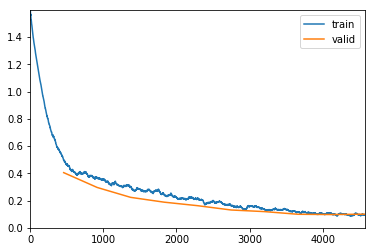

In [ ]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #

In [ ]:
model.save('{}.model'.format(os.path.basename(dataPath)))

In [ ]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.10001929849386215: accuracy: 97.22%


In [ ]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)

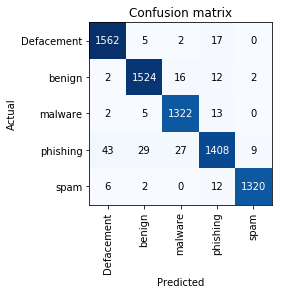

In [ ]:
interp.plot_confusion_matrix(slice_size=10)

In [ ]:
print(interp.confusion_matrix())

[[1562    5    2   17    0]
 [   2 1524   16   12    2]
 [   2    5 1322   13    0]
 [  43   29   27 1408    9]
 [   6    2    0   12 1320]]


In [ ]:
interp.most_confused()

[('phishing', 'Defacement', 43),
 ('phishing', 'benign', 29),
 ('phishing', 'malware', 27),
 ('Defacement', 'phishing', 17),
 ('benign', 'malware', 16),
 ('malware', 'phishing', 13),
 ('benign', 'phishing', 12),
 ('spam', 'phishing', 12),
 ('phishing', 'spam', 9),
 ('spam', 'Defacement', 6),
 ('Defacement', 'benign', 5),
 ('malware', 'benign', 5),
 ('Defacement', 'malware', 2),
 ('benign', 'Defacement', 2),
 ('benign', 'spam', 2),
 ('malware', 'Defacement', 2),
 ('spam', 'benign', 2)]

## Binary-class classification
- Relabel spam, phishing, defacement, malware as 'malicious'
- Keep benign type as benign

In [ ]:
lblTypes = list(lblTypes)
lblTypes

['malware', 'spam', 'benign', 'phishing', 'Defacement']

In [ ]:
lblTypes = dict(zip(lblTypes, ['malicious']*5))
lblTypes['benign'] = 'benign'
lblTypes

{'malware': 'malicious',
 'spam': 'malicious',
 'benign': 'benign',
 'phishing': 'malicious',
 'Defacement': 'malicious'}

In [ ]:
df[label] = df[label].map(lblTypes)

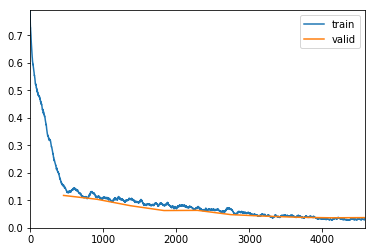

In [ ]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10)

In [ ]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.03709198907017708: accuracy: 98.72%


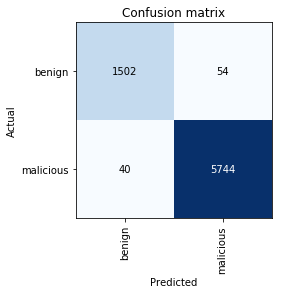

In [ ]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix(slice_size=10)

In [ ]:
df1.shape

(36697, 80)